In [3]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
%matplotlib inline

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


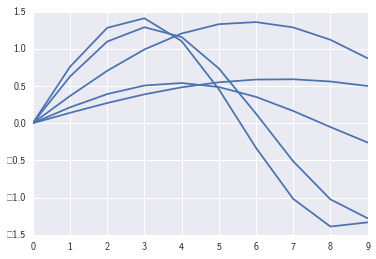

In [13]:
SEQ_LEN = 10
def create_time_series():
    freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
    ampl = np.random.random() + 0.5  # 0.5 to 1.5
    x = np.sin(np.arange(0, SEQ_LEN) * freq) * ampl
    return x

for i in range(0, 5):
    sns.tsplot(create_time_series() );  # 5 series

In [6]:
def to_csv(filename, N):
    with open(filename, 'w') as ofp:
        for lineno in range(0, N):
            seq = create_time_series()
            line = ",".join(map(str, seq))
            ofp.write(line + '\n')

to_csv('train.csv', 1000)  # 1000 sequences
to_csv('valid.csv',  50)

In [7]:
!ls -l

total 284
drwxrwxrwx 2 root root   4096 Sep  5 16:37 data
-rw-r--r-- 1 root root  37425 Sep  7 17:20 rnn_test.ipynb
-rw-r--r-- 1 root root  96911 Sep  7 17:06 test_data.ipynb
-rw-r--r-- 1 root root 137753 Sep  7 17:21 train.csv
-rw-r--r-- 1 root root   6900 Sep  7 17:21 valid.csv


# RNN
## For more info, see:
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for the theory
* https://www.tensorflow.org/tutorials/recurrent for explanations
* https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb for sample code

Here, we are trying to predict from 8 values of a timeseries, the next two values.

# Imports
Several tensorflow packages and shuti

In [15]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [17]:
DEFAULTS = [[0.0] for x in range(0, SEQ_LEN)]
BATCH_SIZE = 20
TIMESERIES_COL = 'rawdata'
N_OUTPUTS = 2  # in each sequence, 1-8 are features, and 9-10 is label
N_INPUTS = SEQ_LEN - N_OUTPUTS

In [21]:
# read data and convert to needed format
def read_dataset(filename, mode=tf.contrib.learn.ModeKeys.TRAIN):  
    def _input_fn():
        num_epochs = 100 if mode == tf.contrib.learn.ModeKeys.TRAIN else 1

        # could be a path to one file or a file pattern.
        input_file_names = tf.train.match_filenames_once(filename)

        filename_queue = tf.train.string_input_producer(
            input_file_names, 
            num_epochs=num_epochs, 
            shuffle=True
        )
        reader = tf.TextLineReader()
        _, value = reader.read_up_to(filename_queue, num_records=BATCH_SIZE)

        value_column = tf.expand_dims(value, -1)
        print('readcsv={}'.format(value_column))

        # all_data is a list of tensors
        all_data = tf.decode_csv(value_column, record_defaults=DEFAULTS)  
        # first few values
        inputs = all_data[:len(all_data) - N_OUTPUTS]  
        label = all_data[len(all_data)-N_OUTPUTS : ] # last few values

        # from list of tensors to tensor with one more dimension
        inputs = tf.concat(inputs, axis=1)
        label = tf.concat(label, axis=1)
        print('inputs={}'.format(inputs))

        return {TIMESERIES_COL: inputs}, label   # dict of features, label
    return _input_fn

## Define RNN
A recursive neural network consists of possibly stacked LSTM cells.

The RNN has one output per input, so it will have 8 output cells. We use only the last output cell, but rather use it directly, we do a matrix multiplication of that cell by a set of weights to get the actual predictions. This allows for a degree of scaling between inputs and predictions if necessary (we don't really need it in this problem).

Finally, to supply a model function to the Estimator API, you need to return a ModelFnOps. The rest of the function creates the necessary objects.

In [24]:
LSTM_SIZE = 3  # number of hidden layers in each of the LSTM cells

# create the inference model
def simple_rnn(features, targets, mode):
    # 0. Reformat input shape to become a sequence
    x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
    #print 'x={}'.format(x)

    # 1. configure the RNN
    lstm_cell = rnn.BasicLSTMCell(
        LSTM_SIZE, forget_bias=1.0
    )
    outputs, _ = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # slice to keep only the last cell of the RNN
    outputs = outputs[-1]
    #print 'last outputs={}'.format(outputs)

    # output is result of linear activation of last layer of RNN
    weight = tf.Variable(
        tf.random_normal([LSTM_SIZE, N_OUTPUTS])
    )
    bias = tf.Variable(
        tf.random_normal([N_OUTPUTS])
    )
    predictions = tf.matmul(outputs, weight) + bias
    
    
    # 2. loss function, training/eval ops
    if mode == tf.contrib.learn.ModeKeys.TRAIN or mode == tf.contrib.learn.ModeKeys.EVAL:
        loss = tf.losses.mean_squared_error(targets, predictions)
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=0.01,
            optimizer="SGD")
        eval_metric_ops = {
          "rmse": tf.metrics.root_mean_squared_error(targets, predictions)
        }
    else:
        loss = None
        train_op = None
        eval_metric_ops = None

    # 3. Create predictions
    predictions_dict = {"predicted": predictions}
  
    # 4. return ModelFnOps
    return tflearn.ModelFnOps(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops
    )

In [26]:
def breakup(sess, x, lookback_len):
    N = sess.run(tf.size(x))
    windows = [tf.slice(x, [b], [lookback_len]) for b in xrange(0, N-lookback_len)]
    windows = tf.stack(windows)
    return windows

In [25]:
def get_train():
    return read_dataset('train.csv', mode=tf.contrib.learn.ModeKeys.TRAIN)

def get_valid():
    return read_dataset('valid.csv', mode=tf.contrib.learn.ModeKeys.EVAL)

def serving_input_fn():
    feature_placeholders = {
        TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
    }

    features = {
      key: tf.expand_dims(tensor, -1)
      for key, tensor in feature_placeholders.items()
    }
    features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2])
    
    print('serving: features={}'.format(features[TIMESERIES_COL]))
    
    return tflearn.utils.input_fn_utils.InputFnOps(
      features,
      None,
      feature_placeholders
    )


from tensorflow.contrib.learn.python.learn.utils import saved_model_export_utils

def experiment_fn(output_dir):
    # run experiment
    return tflearn.Experiment(
        tflearn.Estimator(model_fn=simple_rnn, model_dir=output_dir),
        train_input_fn=get_train(),
        eval_input_fn=get_valid(),
        eval_metrics={
            'rmse': tflearn.MetricSpec(
                metric_fn=metrics.streaming_root_mean_squared_error
            )
        },
        export_strategies=[saved_model_export_utils.make_export_strategy(
            serving_input_fn,
            default_output_alternative_key=None,
            exports_to_keep=1
        )]
    )

shutil.rmtree('outputdir', ignore_errors=True) # start fresh each time
learn_runner.run(experiment_fn, 'outputdir')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_task_type': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_master': '', '_save_checkpoints_steps': None, '_model_dir': 'outputdir', '_session_config': None, '_task_id': 0, '_num_worker_replicas': 0, '_evaluation_master': '', '_is_chief': True, '_tf_random_seed': None, '_environment': 'local', '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f64e07a27b8>}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
readcsv=Tensor("ExpandDims:0", shape=(?, 1), dtype=string)
inputs=Tensor("concat:0", shape=(?, 8), dtype=float32)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into outputdir/model.ckpt.
readcsv=Tensor

({'global_step': 5000, 'loss': 0.033274516, 'rmse': 0.17089742},
 [b'outputdir/export/Servo/1504815552'])